# Regressão Softmax com dados do MNIST

**Aluno:**

* Marcos Madruga (mcmap@cesar.school)

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.autograd import Variable
import torch
import torchvision

In [2]:
torch.manual_seed(12345)

## Carregamento dos dados do MNIST

In [3]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [4]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [5]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

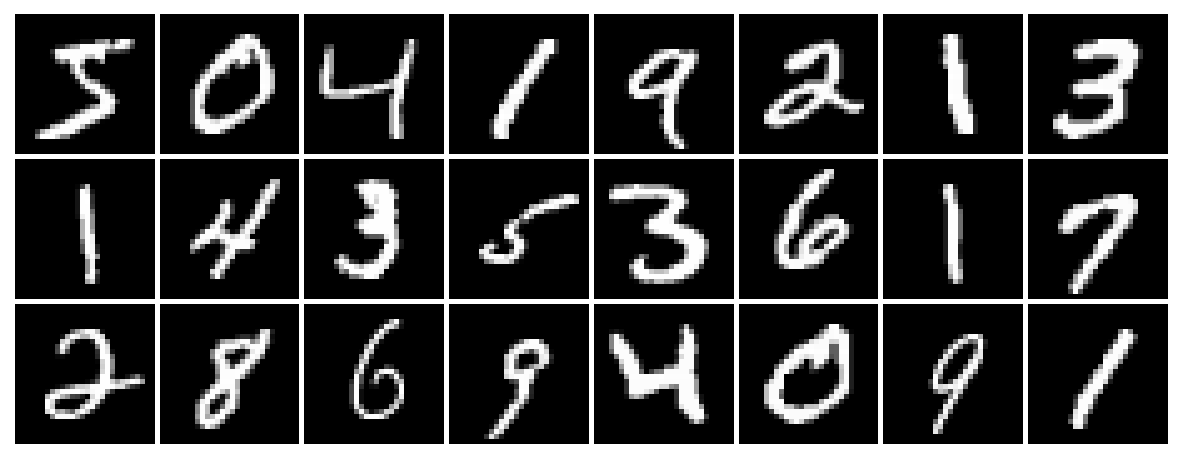

In [6]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


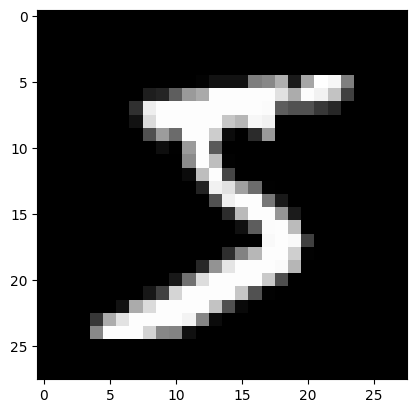

In [7]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Modelo

In [8]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [9]:
# Ao fazer a previsão de 3 amostras vemos que o resultado está correto
# no que se refere ao número de dimensões: 3 saídas com 10 valores cada.

import torch.nn.functional as F

x_pred = x_train[:3].view(-1,28*28)
y_pred = model(x_pred)

y_prob = F.softmax(y_pred, dim=1) * 100

print(y_prob.shape)
print(y_prob)

torch.Size([3, 10])
tensor([[ 7.3984,  7.6788, 11.5465, 12.0072,  7.0695,  8.9276, 11.6905, 13.6152,
          8.8907, 11.1757],
        [10.0940,  7.0413, 12.2541, 14.6288,  6.6066,  8.5162,  8.3984,  9.0685,
         11.3687, 12.0234],
        [10.8608,  8.0811,  8.5010, 10.6186,  8.2065,  9.1123, 14.6182,  7.3832,
         12.7590,  9.8595]], grad_fn=<MulBackward0>)


## Treinamento

### Inicialização dos parâmetros

In [10]:
epochs = 50
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [11]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-k9bqh9rb
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-k9bqh9rb
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Preparing metadata (setup.py) ... done


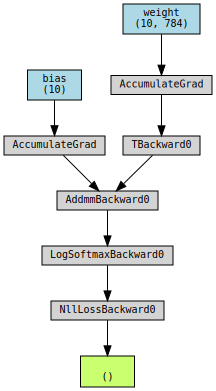

In [12]:
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
from torchviz import make_dot, make_dot_from_trace
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [13]:
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #losses.append(loss.data)
        losses.append(loss.item())
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

except KeyboardInterrupt:
    pass

<Figure size 1800x600 with 0 Axes>

In [14]:
model.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [15]:
print('Final loss:', loss.data)

Final loss: tensor(0.3668)


### Visualizando gráfico de perda durante o treinamento

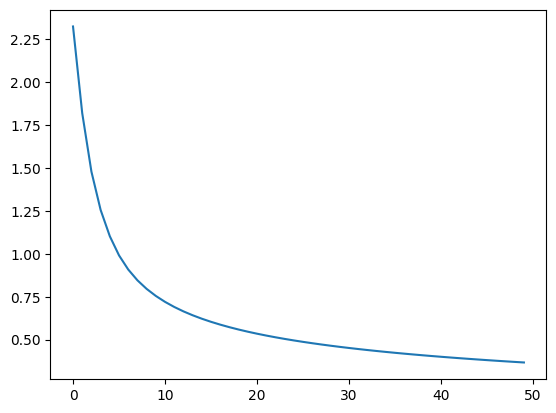

In [16]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [17]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.921


### Matriz de confusão com dados de treinamento e teste

In [18]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,111,4,0,1,0,2,3,1,0
2,0,0,85,2,1,1,0,1,1,1
3,0,0,1,85,0,3,0,0,1,1
4,0,0,1,0,100,2,2,3,0,3
5,0,2,0,2,0,79,0,0,3,1
6,1,0,1,1,2,2,88,0,0,0
7,0,1,3,1,0,0,0,109,0,4
8,0,2,2,0,0,2,1,0,80,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


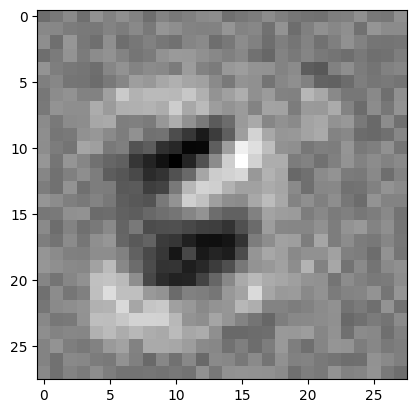

In [19]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

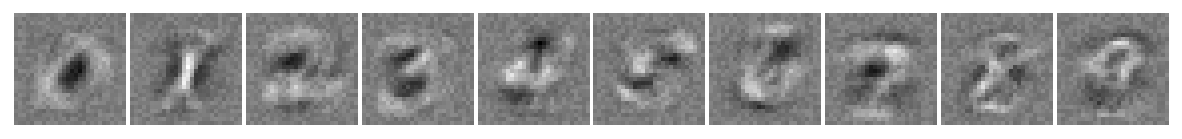

In [20]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [21]:
# Resposta 1

from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #losses.append(loss.data)
        losses.append(loss.item())
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

        print(f'Época {i+1}/{epochs} - Perda:{loss:.8} - Acurácia:{accuracy}')

except KeyboardInterrupt:
    pass

Época 1/50 - Perda:2.3302319 - Acurácia:0.076
Época 2/50 - Perda:1.8229883 - Acurácia:0.588
Época 3/50 - Perda:1.4809281 - Acurácia:0.766
Época 4/50 - Perda:1.2575978 - Acurácia:0.762
Época 5/50 - Perda:1.1055253 - Acurácia:0.809
Época 6/50 - Perda:0.99514747 - Acurácia:0.815
Época 7/50 - Perda:0.9132598 - Acurácia:0.829
Época 8/50 - Perda:0.84992993 - Acurácia:0.836
Época 9/50 - Perda:0.79929793 - Acurácia:0.843
Época 10/50 - Perda:0.75761557 - Acurácia:0.849
Época 11/50 - Perda:0.72252762 - Acurácia:0.858
Época 12/50 - Perda:0.6924656 - Acurácia:0.861
Época 13/50 - Perda:0.66633558 - Acurácia:0.867
Época 14/50 - Perda:0.64334702 - Acurácia:0.869
Época 15/50 - Perda:0.6229127 - Acurácia:0.871
Época 16/50 - Perda:0.60458678 - Acurácia:0.873
Época 17/50 - Perda:0.58802402 - Acurácia:0.875
Época 18/50 - Perda:0.57295322 - Acurácia:0.876
Época 19/50 - Perda:0.55915743 - Acurácia:0.877
Época 20/50 - Perda:0.54646122 - Acurácia:0.878
Época 21/50 - Perda:0.53472126 - Acurácia:0.881
Época 22/

<Figure size 1800x600 with 0 Axes>

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

In [22]:
# Resposta 1

from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #losses.append(loss.data)
        losses.append(loss.item())
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

        print(f'\nÉpoca {i+1}/{epochs} - Perda:{loss:.8} - Acurácia:{accuracy}')
        for name, param in model.named_parameters():
            if param.grad is not None:
                #print(f'param.grad.shape: {param.grad.shape}')
                print(f'{name}: gradiente = {param.grad[4]}')
                #print(f"{name}: gradiente médio = {param.grad.mean():.6f}, "
                #      f"máximo = {param.grad.max():.6f}, mínimo = {param.grad.min():.6f}")

except KeyboardInterrupt:
    pass

A saída de streaming foi truncada nas últimas 5000 linhas.
         3.4117e-05,  1.3361e-04,  7.0588e-04,  1.3592e-03,  2.0497e-03,
         3.2364e-03,  3.6443e-03,  4.2498e-03,  3.8981e-03,  3.0714e-03,
         3.7620e-03,  1.6527e-03, -1.5162e-03,  3.9729e-04,  9.6645e-04,
         1.0031e-03, -2.2356e-04,  1.0616e-03,  3.1600e-04, -6.9325e-04,
         1.1506e-04,  1.1727e-04,  1.9097e-05,  5.7365e-06,  1.2868e-05,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  7.5073e-07,  4.5747e-05,
         2.9355e-04,  8.0966e-04,  1.4683e-03,  1.6641e-03,  2.1818e-03,
         2.9314e-03,  1.6747e-03,  1.4960e-03,  2.5395e-03, -4.8412e-04,
        -1.3752e-03, -5.3261e-04,  2.4181e-04,  1.2963e-04, -9.3314e-04,
         2.4847e-04, -2.4523e-04, -6.2517e-04, -6.9564e-05,  1.0381e-04,
         1.8002e-05,  2.9497e-06,  6.7558e-06,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  5.6139e-08,  5.9743e-05,  2.7093e-04,  5.3061e-04,
         7.4616e-04,  8.5511e-04,  1.5573e-03,  8.2112e-04,  3.89

<Figure size 1800x600 with 0 Axes>

<details>
<summary>Mostrar Resultado</summary>

```python
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        weights_d = model.weight.data[4].numpy().reshape(28,28)
        weights_g = model.weight.grad.data[4].numpy().reshape(28,28)
        ww = np.concatenate((weights_d,weights_g),1)
        plt.imshow(ww.reshape((28,28*2)),cmap = 'gray')
        display.display(fig)
        display.clear_output(wait=True)
        input(i)
        
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()
        print('Accuracy:', accuracy)
        print("epoca: " + str(i + 1))
        print("perda: " + str(loss.data.detach().numpy()))
except KeyboardInterrupt:
    pass
```

</details>



## Perguntas

1. Qual é o shape da matriz de entrada na rede? [60000, 784]
2. Qual é o shape da saída da rede? [60000, 10]
3. Qual é o número total de parâmetros da rede, incluindo o bias? 7850

# Aprendizados
